Test porfolio optimization and diversification calculations

In [166]:
import pandas as pd
import datetime
import numpy as np
import pickle
import sklearn
import networkx as nx

# add path to other folders, to import
import sys, os
sys.path.append(os.path.abspath(".."))
from util import fetch_raw_data

In [151]:
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
spectralGraphTopology = importr('spectralGraphTopology')
igraph = importr('igraph')
fingraph = importr('fingraph')
fitHeavyTail = importr('fitHeavyTail')
huge = importr('huge')


Load data

In [148]:
return_pivot, esg_pivot, sector_classification = fetch_raw_data("C:/Users/User/Code/MMD_Graph_Diversification/")
# esg smoothed stock
with open("../data/tidy/gp_esg_stock_data_frame.pkl", "rb") as input_file:
   gp_esg_stock_data_frame = pickle.load(input_file)


2014-10-01 00:00:00
2022-02-01 00:00:00


diversification functions

In [312]:
def div_ratio(w, cov):
  # numerator is perfect correlation
  # denom is portfolio risk
  return np.inner(w, np.sqrt(np.diag(cov)))/np.sqrt(np.dot(w, cov).dot(w))

def var_div_ratio(w,data, q = 0.95):
  # w weights
  # d = data

  ind_var = []
  for col in range(data.shape[1]):
      ind_var.append(np.quantile(-data[:,col], q))

  port_var = np.quantile(np.dot(-data, w), q)

  return port_var/np.inner(ind_var,w)




Estimate the correlation for some sector using various methods. Look at the weights, diversification for different methods

In [361]:

sector = 'Industrials'
rolling_window_size = 150
time_i = 300

normal_div_gmv_dict = {}
var_div_gmv_dict = {}

current_returns = return_pivot.loc[:,np.isin(return_pivot.columns,sector_classification[sector])].iloc[(time_i - rolling_window_size):time_i]
current_returns = current_returns.iloc[:,:]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
current_return_scaled = scaler.fit_transform(current_returns)

X = np.array(current_returns)
scaler = StandardScaler()
X = scaler.fit_transform(X)
#out_heavy_no_constraint = fingraph.learn_regular_heavytail_graph(X, heavy_type = "student", nu = 4, verbose = False)
#out_heavy_no_constraint = dict(zip(out_heavy_no_constraint.names, list(out_heavy_no_constraint)))
#precision_matrix =out_heavy_no_constraint['laplacian']
#precision_matrix = precision_matrix + 0.0001*np.identity(precision_matrix.shape[0])
#S = np.linalg.inv(precision_matrix)

out = huge.huge(X, method = 'glasso', nlambda = 30,verbose = False)
out_select = huge.huge_select(out, criterion = "ebic", stars_thresh = 0.1, rep_num = 10,ebic_gamma = 0.45 )
out_select = dict(zip(out_select.names, list(out_select)))
precision_matrix = out_select['opt.icov'].copy()
S = np.linalg.inv(precision_matrix)

mu = current_returns.mean()

# GMV diversification
w_gmv = np.dot(precision_matrix, np.ones(S.shape[0]))/np.dot(np.ones(S.shape[0]), precision_matrix).dot(np.ones(S.shape[0])) 
print(div_ratio(w_gmv,S))
print(var_div_ratio(w_gmv,X))
# SHARPE
w_sharpe = np.dot(precision_matrix, mu)/np.dot(np.ones(S.shape[0]), precision_matrix).dot(mu)
print(div_ratio(w_sharpe,S))
print(var_div_ratio(w_sharpe,X))
# Uniform
w_uni = np.ones(S.shape[1])/S.shape[1]
print(div_ratio(w_uni,S))
print(var_div_ratio(w_uni,X))

Conducting extended Bayesian information criterion (ebic) selection....done
2.053141744495812
0.6559439792462164
0.48494307984330337
2.11881284696906
1.5363011095557308
0.7565528650879014


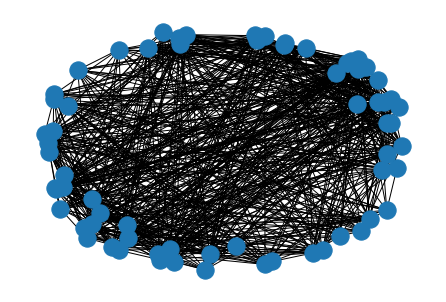

In [362]:
ok = out_select['opt.icov'].copy()
np.fill_diagonal(ok,0)
nx.draw(nx.from_numpy_array(ok))

In [365]:
np.sum(ok >0)

54

# LGMRF test

In [91]:
X = np.array(current_returns)
out_heavy_no_constraint = fingraph.learn_regular_heavytail_graph(X, heavy_type = "student", nu = 4, verbose = False)
out_heavy_no_constraint = dict(zip(out_heavy_no_constraint.names, list(out_heavy_no_constraint)))
precision_matrix =out_heavy_no_constraint['laplacian']

In [154]:

precision_matrix

array([[ 1.00009994, -0.01536907, -0.01495169, ..., -0.01518425,
        -0.01522553, -0.01509827],
       [-0.01536907,  1.00009997, -0.0152619 , ..., -0.01580301,
        -0.01516547, -0.01498821],
       [-0.01495169, -0.0152619 ,  1.00009996, ..., -0.0150602 ,
        -0.01501134, -0.01514713],
       ...,
       [-0.01518425, -0.01580301, -0.0150602 , ...,  1.00009998,
        -0.01487211, -0.01492325],
       [-0.01522553, -0.01516547, -0.01501134, ..., -0.01487211,
         1.00009998, -0.01561482],
       [-0.01509827, -0.01498821, -0.01514713, ..., -0.01492325,
        -0.01561482,  1.00009997]])

In [155]:
l,u = np.linalg.eigh(precision_matrix)

new_prec = precision_matrix + 0.001*np.identity(precision_matrix.shape[0])#np.ones(precision_matrix.shape)/precision_matrix.shape[0]#np.dot(u[:,3:], np.diag(l[3:])).dot(u[:,3:].T)
np.dot(new_prec, np.ones(S.shape[0]))/np.dot(np.ones(S.shape[0]), new_prec).dot(np.ones(S.shape[0]))


array([0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537])

# huge test

In [322]:
out = huge.huge(X, method = 'glasso', nlambda = 30,verbose = False)
out_select = huge.huge_select(out, criterion = "ebic" )
out_select = dict(zip(out_select.names, list(out_select)))

Conducting extended Bayesian information criterion (ebic) selection....done


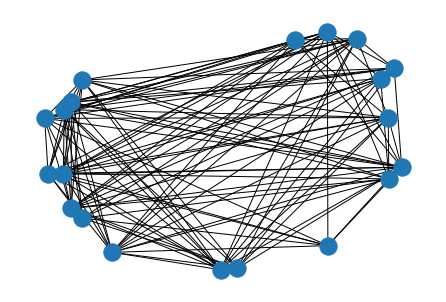

In [323]:
ok = out_select['opt.icov'].copy()
np.fill_diagonal(ok,0)
nx.draw(nx.from_numpy_array(ok))

In [271]:
precision_matrix = out_select['opt.icov']
S = np.linalg.inv(precision_matrix)

mu = current_returns.mean()

# GMV diversification
w_gmv = np.dot(precision_matrix, np.ones(S.shape[0]))/np.dot(np.ones(S.shape[0]), precision_matrix).dot(np.ones(S.shape[0])) 
print(div_ratio(w_gmv,S))
print(var_div_ratio(w_gmv,X))
# SHARPE
w_sharpe = np.dot(precision_matrix, mu)/np.dot(np.ones(S.shape[0]), precision_matrix).dot(mu)

print(div_ratio(w_sharpe,S))
print(var_div_ratio(w_sharpe,X))
# Uniform
w_uni = np.ones(S.shape[1])/S.shape[1]
print(div_ratio(w_uni,S))
print(var_div_ratio(w_uni,X))

1.6908233896631761
20.639021665967928
0.5428344252501084
9.605225133042124
1.533620187777643
24.66903615007165


In [267]:
np.linalg.inv(out_select['opt.icov'])

array([[1.0856456 , 0.40073374, 0.36595961, 0.4685659 , 0.43682617,
        0.34873255, 0.34375657, 0.45584939, 0.37042821, 0.36279258,
        0.4300121 , 0.20059154, 0.32961721, 0.3248582 , 0.35012999,
        0.31101819, 0.2751706 , 0.343989  , 0.2416259 , 0.36050312],
       [0.40076885, 1.08569566, 0.52038751, 0.51794083, 0.56459211,
        0.51293539, 0.45564988, 0.43873282, 0.45786883, 0.51657704,
        0.44374658, 0.27725042, 0.5039837 , 0.4758049 , 0.49826304,
        0.39328093, 0.28196962, 0.36882027, 0.25259319, 0.51793307],
       [0.365959  , 0.52032222, 1.08564542, 0.48811697, 0.55828696,
        0.55658329, 0.44674621, 0.43059558, 0.46507239, 0.58969563,
        0.43780987, 0.28873752, 0.49778584, 0.48605093, 0.54314735,
        0.51523806, 0.30238978, 0.43152242, 0.26624814, 0.53292964],
       [0.46857025, 0.51789489, 0.4881329 , 1.08565262, 0.53022465,
        0.42919216, 0.45163254, 0.49251059, 0.52231844, 0.4530651 ,
        0.45257388, 0.24479613, 0.40566815, 0

# sklearn glasso

c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


array([-9497.79000667, -5672.67667884, -3902.94917592, -1850.46869785,
       -1480.05407468, -1116.19616615,  -797.53669138,  -493.33256637,
          46.1388955 ,   306.93429541,   655.08454244,  1307.29924656,
        1776.51585994,  1819.13072536,  2113.12217376,  2425.87175987,
        2801.11524297,  3378.19006706,  3596.06281377,  4585.53843523])

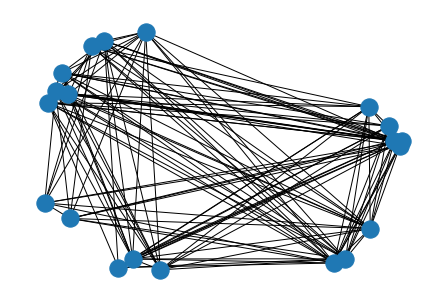

In [350]:
from sklearn.covariance import GraphicalLassoCV
glasso = GraphicalLassoCV(cv = 3).fit(X[:, :20])

ok = glasso.precision_
np.fill_diagonal(ok,0)

nx.draw(nx.from_numpy_array(ok))
l,u = np.linalg.eigh(ok)
l


In [353]:
np.linalg.inv(np.cov(X.T))

array([[33296.54488788,   130.1576352 ,   556.0730679 , ...,
         5024.81927868,  -403.3110298 ,  -702.31223895],
       [  130.1576352 , 21652.80452904, -1702.82786107, ...,
        -2948.24444134, -1182.37042   ,  1515.92449253],
       [  556.0730679 , -1702.82786107, 19018.62701822, ...,
         1241.1691842 ,  -966.59118403, -1193.54552925],
       ...,
       [ 5024.81927868, -2948.24444134,  1241.1691842 , ...,
        19858.81316626,  1358.82496798,   -85.80945303],
       [ -403.3110298 , -1182.37042   ,  -966.59118403, ...,
         1358.82496798, 16919.18151784, -1701.24887848],
       [ -702.31223895,  1515.92449253, -1193.54552925, ...,
          -85.80945303, -1701.24887848, 10023.60085854]])

In [251]:
glasso.cv_results_

c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\sklearn\covariance\_graph_lasso.py:88: FutureWarning: Key: 'split0_score', is deprecated in 1.0 and will be removed in 1.2. Use 'split0_test_score' instead
  warnings.warn(
c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\sklearn\covariance\_graph_lasso.py:88: FutureWarning: Key: 'split1_score', is deprecated in 1.0 and will be removed in 1.2. Use 'split1_test_score' instead
  warnings.warn(
c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\sklearn\covariance\_graph_lasso.py:88: FutureWarning: Key: 'split2_score', is deprecated in 1.0 and will be removed in 1.2. Use 'split2_test_score' instead
  warnings.warn(
c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\sklearn\covariance\_graph_lasso.py:88: FutureWarning: Key: 'mean_score', is deprecated in 1.0 and will be removed in 1.2. Use 'mean_test_score' instead
  warnings.warn(
c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\sklearn\covariance\_graph_lasso.

{'alphas': array([4.51964974e-04, 9.73729020e-05, 7.16316211e-05, 5.26952473e-05,
        3.87648505e-05, 2.85170620e-05, 2.68187242e-05, 2.52215311e-05,
        2.37194590e-05, 2.23068431e-05, 2.20345802e-05, 2.17656402e-05,
        2.14999828e-05, 2.12375679e-05, 2.09783558e-05, 4.51964974e-06,
        0.00000000e+00]),
 'split0_test_score': array([56.09079256, 59.40679569, 60.81377733, 61.54487643, 61.93829646,
        62.16071445, 62.1904642 , 62.21644787, 62.23847607, 62.25694212,
        62.26024062, 62.26341358, 62.26646318, 62.26939069,        -inf,
               -inf, 61.42955913]),
 'split0_score': array([56.09079256, 59.40679569, 60.81377733, 61.54487643, 61.93829646,
        62.16071445, 62.1904642 , 62.21644787, 62.23847607, 62.25694212,
        62.26024062, 62.26341358, 62.26646318, 62.26939069,        -inf,
               -inf, 61.42955913]),
 'split1_test_score': array([57.84266543, 60.52443283, 61.38003725, 62.01249151, 62.43385801,
        62.70356454, 62.74274605, 6

# GGLasso

In [229]:
from gglasso.problem import glasso_problem
P = glasso_problem(np.cov(X.T), X.shape[0], reg_params = {'lambda1': 0.05}, latent = False, do_scaling = False)

In [235]:
lambda1_range = np.logspace(0, -3, 30)
modelselect_params = {'lambda1_range': lambda1_range}

P.model_selection(modelselect_params = modelselect_params, method = 'eBIC', gamma = 0.1)
P.solution.precision_

array([[10712.72339524,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,  6828.87183737,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,  4521.98943156, ...,
            0.        ,     0.        ,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
         6557.7521005 ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,  6412.8475339 ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,  3884.60172106]])

In [236]:
P.solution.precision_

array([[10712.72339524,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,  6828.87183737,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,  4521.98943156, ...,
            0.        ,     0.        ,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
         6557.7521005 ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,  6412.8475339 ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,  3884.60172106]])

In [237]:
from gglasso.helper.data_generation import generate_precision_matrix, group_power_network, sample_covariance_matrix
from gglasso.problem import glasso_problem
from gglasso.helper.basic_linalg import adjacency_matrix

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

p = 20
N = 1000

Sigma, Theta = generate_precision_matrix(p=p, M=1, style='erdos', prob=0.1, seed=1234)

S, sample = sample_covariance_matrix(Sigma, N)

print("Shape of empirical covariance matrix: ", S.shape)
print("Shape of the sample array: ", sample.shape)

Shape of empirical covariance matrix:  (20, 20)
Shape of the sample array:  (20, 1000)


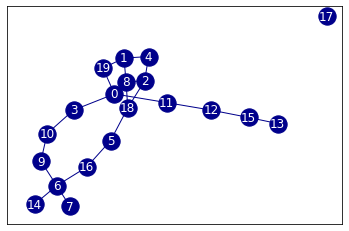

In [238]:
A = adjacency_matrix(Theta)

G = nx.from_numpy_array(A)
pos = nx.drawing.layout.spring_layout(G, seed = 1234)

plt.figure()
nx.draw_networkx(G, pos = pos, node_color = "darkblue", edge_color = "darkblue", font_color = 'white', with_labels = True)

In [239]:
P = glasso_problem(S, N, reg_params = {'lambda1': 0.05}, latent = False, do_scaling = False)
print(P)

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}


In [240]:
lambda1_range = np.logspace(0, -3, 30)
modelselect_params = {'lambda1_range': lambda1_range}

P.model_selection(modelselect_params = modelselect_params, method = 'eBIC', gamma = 0.1)

# regularization parameters are set to the best ones found during model selection
print(P.reg_params)

ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 32 iterations with status: optimal.
ADMM terminated after 32 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 37 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated 

In [241]:
np.linalg.eigh(P.solution.precision_)

(array([0.35032749, 0.51360373, 0.59866797, 0.63364128, 0.84550003,
        0.86330357, 0.88314453, 0.88477144, 0.92308544, 0.97858934,
        0.99189372, 1.02415215, 1.03237539, 1.04370464, 1.11608856,
        1.13912686, 1.33345918, 1.34835067, 1.36309521, 1.44802635]),
 array([[-2.82478716e-03,  2.28333233e-02, -3.28402389e-01,
         -1.49939687e-02,  5.44356253e-01,  1.64315323e-03,
          1.90616186e-01,  1.40512848e-02, -7.47372649e-04,
          1.86486786e-02,  6.81066658e-05, -2.37763805e-05,
          4.74944939e-17,  5.15566535e-04,  6.27413243e-01,
         -1.55048941e-01,  8.74852258e-03, -3.09658490e-01,
         -2.10926236e-01, -6.95450272e-03],
        [-3.22264735e-03,  2.49950078e-01, -1.49287723e-01,
          6.18605373e-01, -7.79739578e-02, -1.76512678e-04,
         -7.79239221e-02, -4.83070286e-03,  2.69941215e-04,
         -2.34602108e-01,  3.28218202e-04, -1.09987010e-02,
          2.17047303e-17, -4.30198603e-05, -5.65737433e-02,
         -1.56519691e-